## Libraries to import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel
import tensorflow as tf

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data and Split

In [2]:
file = pd.read_csv('articles.csv', keep_default_na=True, encoding='cp1252')
l1 = file[file['Tonality'].notna()]
data = l1[l1['Article.Description'].notna()]
data ['Tonality'] = data['Tonality'].map({'Positive': 1, 'Negative': 0, 'Neutral':0})
data['Tonality'] = data['Tonality'].astype('Int64')

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.2)


train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')

data = pd.read_csv('train_df.csv')

## Preprocess

In [3]:
# Removing duplicates
train_df.drop_duplicates('Article.Description', keep='first')

# text cleaning
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = t.replace("<p>","")
        t = t.replace("#","")
        new_text.append(t.lower())
    return " ".join(new_text).strip().replace("  ", " ")


train_df['Article.Description'] = train_df['Article.Description'].apply(preprocess)
train_df.head()

,Id,Heading,Article.Banner.Image,Outlets,Article.Description,Full_Article,Article_Type,Tonality
2851,4ce04c2a-a946-4365-bb80-97585146c430,Apache Deliveries Sharply Lower Pending Safety...,https://www.flightglobal.com/assets/getasset.a...,FlightGlobal,boeing has replaced about 25 percent of the st...,<p>Boeing has replaced about 25 percent of the...,Military,0
594,c3df1ef3-df1f-4442-bb95-0f1c096665a4,Mercedes Vision URBANETIC Unveiled at CES 2019,https://www.geeky-gadgets.com/wp-content/uploa...,Geeky Gadgets,mercedes benz has unveiled a new concept car a...,<p>Mercedes Benz has unveiled a new concept ca...,Commercial,1
11,e1902fb9-ba3e-4262-a94e-302ecdeebfba,"Bell Nexus full-scale air taxi design debuts, ...",https://www.sae.org/binaries/content/gallery/c...,SAE International,"bell, safran, eps, thales, moog, and garmin co...","<p>Bell, Safran, EPS, Thales, Moog, and Garmin...",Commercial,1
1669,bd90f827-ca86-461a-8767-cc444fb089f5,US Army test autonomous flight system for use ...,NaN,Design Products & Applications,"now in phase 3, the sikorsky engineers develop...","<p>Now in Phase 3, the Sikorsky engineers deve...",Military,1
2498,fd4d2d80-cd90-4555-9f77-b186eb5a1f51,Questions About eVTOL Practicality Remain,NaN,AOPA,bell and garmin announced oct. 2 they are team...,<p>Bell and Garmin announced Oct. 2 they are t...,Commercial,1


### Fine Tuning BERT

In [4]:
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


SEQ_LEN = 128
# encoding the training data
train_encoded_inputs = tokenizer(train_df['Article.Description'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length', 
                                 truncation=True, 
                                 max_length=SEQ_LEN, 
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

c:\Python310\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Creating Tensorflow data

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, train_df['Tonality'].values))

# formatting the data as required by bert model
def format_bert(inputs, labels):
  inputs = {'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']}
  
  return inputs, labels

train_dataset = train_dataset.map(format_bert)

#### Creating train and test split

In [6]:
dataset = train_dataset.shuffle(100000).batch(64)

# length of the dataset(total batches)
DS_LEN = len(dataset)

# take 80% for train and 20% for validation
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))

### MODEL

In [7]:
# BERT MODEL
bert = TFAutoModel.from_pretrained('bert-base-uncased')

# create model architecture

# Input layers
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name = 'attention_mask')

# bert embeddings
embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:,0,:]

# keras layers
x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

# output layer
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freezing the pretrained bert layer
model.layers[2].trainable = False
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

##### Training PARAMETER

In [8]:
#learning_rate = 1e-3, 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

### MODEL TRAINING

In [9]:
# train the model
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss')]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    callbacks = callbacks
)


## SAVE MODEL
model.save('TextClassifier.model')

Epoch 1/20
39/39 [==============================] - 34s 612ms/step - loss: 0.3334 - accuracy: 0.8658 - val_loss: 0.2579 - val_accuracy: 0.9186 - lr: 0.0010
Epoch 2/20
39/39 [==============================] - 21s 541ms/step - loss: 0.2095 - accuracy: 0.9259 - val_loss: 0.2264 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 3/20
39/39 [==============================] - 21s 539ms/step - loss: 0.1877 - accuracy: 0.9295 - val_loss: 0.1975 - val_accuracy: 0.9369 - lr: 0.0010
Epoch 4/20
39/39 [==============================] - 21s 539ms/step - loss: 0.1823 - accuracy: 0.9359 - val_loss: 0.1670 - val_accuracy: 0.9502 - lr: 0.0010
Epoch 5/20
39/39 [==============================] - 21s 536ms/step - loss: 0.1653 - accuracy: 0.9403 - val_loss: 0.1187 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 6/20
39/39 [==============================] - 21s 551ms/step - loss: 0.1485 - accuracy: 0.9475 - val_loss: 0.1114 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 7/20
39/39 [==============================] - 21s 544ms/st

INFO:tensorflow:Assets written to: TextClassifier.model\assets


INFO:tensorflow:Assets written to: TextClassifier.model\assets


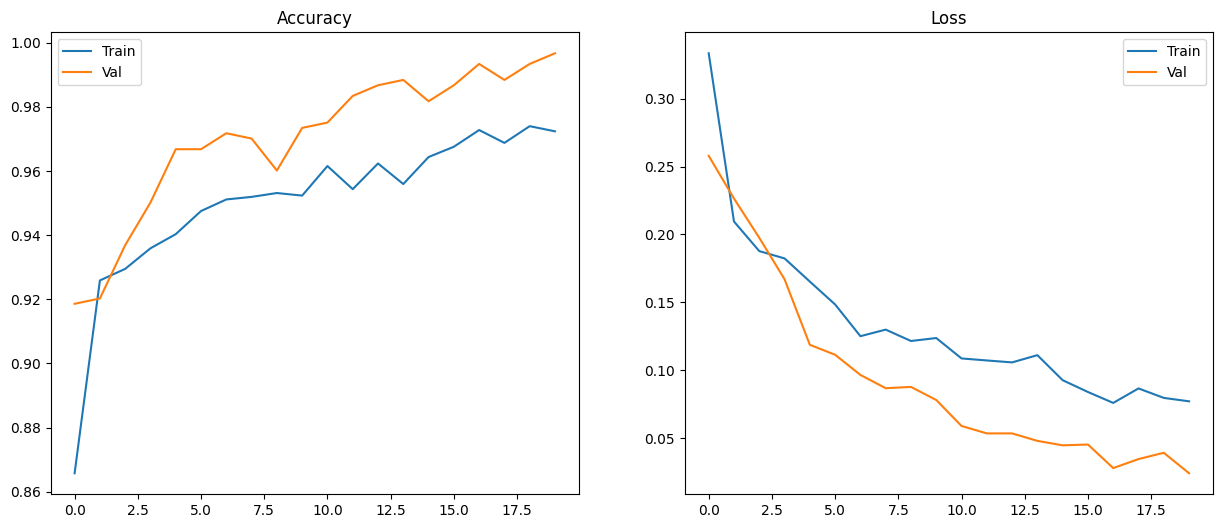

In [10]:
# plot the performance curve
epochs = history.epoch
plt.figure(figsize=(15, 6))

# Accuracy
plt.subplot(1,2, 1)
plt.plot(epochs, history.history['accuracy'], label="Train")
plt.plot(epochs, history.history['val_accuracy'], label = "Val")
plt.legend()
plt.title("Accuracy")

# loss
plt.subplot(1,2, 2)
plt.plot(epochs, history.history['loss'], label="Train")
plt.plot(epochs, history.history['val_loss'], label = "Val")
plt.legend()
plt.title("Loss")

plt.show()

In [11]:
# evaluate on val data
model.evaluate(val_ds)

10/10 [==============================] - 4s 372ms/step - loss: 0.0319 - accuracy: 0.9917


[0.031942907720804214, 0.9916943311691284]

### Make prediction for test data

In [12]:
test_df = pd.read_csv('test_df.csv')

# clean text
test_df['Article.Description'] = test_df['Article.Description'].apply(preprocess)

# encoding the test data
test_encoded_inputs = tokenizer(test_df['Article.Description'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length', 
                                 truncation=True, 
                                 max_length=SEQ_LEN, 
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

# create tf dataset
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encoded_inputs))

In [13]:
# make prediction
test_ds = test_dataset.shuffle(100000).batch(32)
test_pred = model.predict(test_ds)

25/25 [==============================] - 8s 198ms/step


In [14]:
# create the target labels for test data
test_target = np.round(test_pred).flatten()

In [18]:
test_df['Tonality'] = test_target.astype('int')
test_df ['Tonality'] = test_df['Tonality'].map({1 :'Positive', 0:'Negative',3: 'Neutral'})
test_df.head(6)

,Unnamed: 0,Id,Heading,Article.Banner.Image,Outlets,Article.Description,Full_Article,Article_Type,Tonality
0,603,76f6cf4b-221a-46f8-8144-e845aaf8fd35,Mercedes-Benz Vans Showcases Vision Urbanetic ...,http://www.autocarpro.in/userfiles/8df835ef-8a...,Autocar professional,"german car major, mercedes-benz vans presented...","<p>German car major, Mercedes-Benz Vans presen...",Commercial,Positive
1,2115,0a4a411a-21c3-42ea-82c6-1e756bed0890,Bell-Boeing Joint Project Awarded $21M Contrac...,NaN,HeliHub.com,"bell-boeing joint project office, amarillo, te...","<p>Bell-Boeing Joint Project Office, Amarillo,...",Military,Positive
2,590,6134156d-2cc7-4314-b631-bea39fab0dbd,Mercedes-Benz Urbanetic Concept: North America...,https://i.gaw.to/content/photos/36/19/361922_2...,Guide Auto,along with the highly-anticipated eqc all-elec...,<p>Along with the highly-anticipated EQC all-e...,Commercial,Positive
3,308,0d7b6c74-f4a1-481c-968c-ca890ac6848f,CES 2019 transports you to the future,https://im.rediff.com/money/2019/jan/10ces-aut...,Rediff.com,bell nexus is a vertical take-off and landing ...,<p>Bell Nexus is a vertical take-off and landi...,Commercial,Positive
4,2859,8affeb0b-ca96-40cd-b7de-85856c03d6f3,Helibras Delivers Two H135s to Líder Aviação,https://www.stanstednews.com/gallery/1019.jpg,Business Air News,helibras announced the delivery of two h135 he...,<p>Helibras announced the delivery of two H135...,Commercial,Positive
5,2332,aee2af86-e060-4b76-ad95-93679d984429,"McChord AFB represents USAF in Ample Strike, N...",NaN,AF.mil,the uh-1y and 10 marines were transported to t...,<p>The UH-1Y and 10 Marines were transported t...,Military,Negative
